In [40]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import quandl
from init_objects import *
from simfinmodel import *
from functions.helpers import hurst

# Fundamentals unhinged replication notebook

In [2]:
NRUNS = 10

In [28]:
parameters = {
    # global parameters
    "n_traders": 1000,
    "ticks": 2500,
    "trader_sample_size": 6,
    "fundamental_value": 100,
    "std_fundamental": 0.08,
    "std_noise": 0.15,
    "std_vol": 4,
    "max_order_expiration_ticks": 50,
    # trader parameters
    "w_fundamentalists": 0.0,
    "w_momentum": 90.0,
    "w_random": 20.0,
    "w_mean_reversion": 20.0,
    "w_buy_hold": 0.0,
    "spread_max": 0.05,
    "horizon_min": 2,
    "horizon_max": 8,
}

## Baseline monte carlo simulations

In [29]:
traders = []
obs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects(parameters)
    traders, orderbook = sim_fin_model(traders, orderbook, parameters, seed)
    traders.append(traders)
    obs.append(orderbook)

## Model Baseline Dynamics

In [33]:
burn_in_period = 100 

In [34]:
def organise_data(obs):
    window = 20
    close_price = []
    returns = []
    autocorr_returns = []
    autocorr_abs_returns = []
    returns_volatility = []
    volume = []
    fundamentals = []
    for ob in obs: # record
        # close price
        close_price.append(ob.tick_close_price[burn_in_period:])
        # returns
        r = pd.Series(np.array(ob.tick_close_price)).pct_change()
        returns.append(r)
        # autocorrelation returns
        ac_r = [r.autocorr(lag=lag) for lag in range(25)]
        autocorr_returns.append(ac_r)
        # autocorrelation absolute returns
        absolute_returns = pd.Series(r).abs()
        autocorr_abs_returns.append([absolute_returns.autocorr(lag=lag) for lag in range(25)])
        # volatility of returns
        roller_returns = r.rolling(window)
        returns_volatility.append(roller_returns.std(ddof=0))
        # volume
        volume.append([sum(volumes) for volumes in ob.transaction_volumes_history][burn_in_period:])
        # fundamentals 
        fundamentals.append(ob.fundamental[burn_in_period:])
    mc_prices = pd.DataFrame(close_price).transpose()
    mc_returns = pd.DataFrame(returns).transpose()
    mc_autocorr_returns = pd.DataFrame(autocorr_returns).transpose()
    mc_autocorr_abs_returns = pd.DataFrame(autocorr_abs_returns).transpose()
    mc_volatility = pd.DataFrame(returns_volatility).transpose()
    mc_volume = pd.DataFrame(volume).transpose()
    mc_fundamentals = pd.DataFrame(fundamentals).transpose()
    
    return mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals

In [35]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(obs)

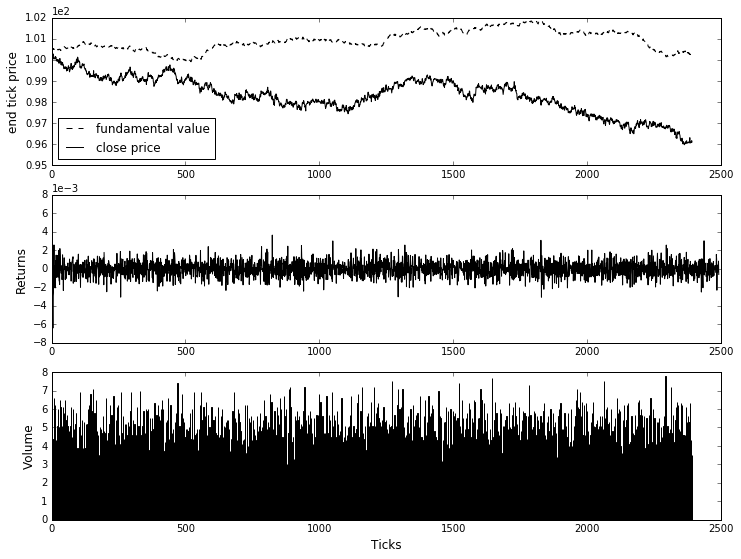

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,9))

ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), 'k--', label='fundamental value')
ax1.plot(mc_prices.index, mc_prices.mean(axis=1), 'k-', label='close price')
ax1.set_ylabel('end tick price', fontsize='12')
ax1.legend(loc='best')

ax2.plot(mc_returns.index, mc_returns.mean(axis=1), 'k-')
ax2.set_ylabel('Returns', fontsize='12')

# ax3.plot(mc_volatility.index, mc_volatility.mean(axis=1), 'k-')
# ax3.set_ylabel('volatility', fontsize='12')

ax3.bar(mc_volume.index, mc_volume.mean(axis=1), color='k', edgecolor='k')
ax3.set_ylabel('Volume', fontsize='12')
ax3.set_xlabel('Ticks', fontsize='12')

for ax in [ax1, ax2, ax3]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    
fig.savefig('model_dynamics.png')

# Stylized facts

## S&P500 data

In [46]:
start_date = '1980-01-01'
end_date = '2017-12-31'

spy_real_price = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_real_price = spy_real_price.rename(columns={"Value": "price"})
spy_dividends = quandl.get("MULTPL/SP500_DIV_MONTH", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_dividends = spy_dividends.rename(columns={"Value": "dividends"})
spy_dividends['new_index'] = range(1, len(spy_dividends)+1)
spy_dividends= spy_dividends.set_index('new_index')
spy_real_price['new_index'] = range(0, len(spy_dividends))
spy_real_price= spy_real_price.set_index('new_index')
spy_all = pd.concat([spy_dividends, spy_real_price], axis=1)
spy_all['pd'] = spy_all['price'] / spy_all['dividends']
spy_all['spy_dev_fund'] = (spy_all['price'] - spy_all['dividends']) / spy_all['dividends']

spy_returns = spy_all['price'].pct_change()
autocorr_spy_returns = [spy_returns.autocorr(lag=lag) for lag in range(25)]

absolute_spy_returns = spy_returns.abs()
autocorr_spy_abs_returns = [absolute_spy_returns.autocorr(lag=lag) for lag in range(25)]

## No autocorrelation in returns + volatility clustering

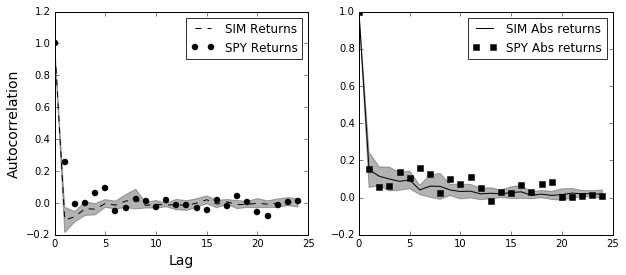

In [51]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

lenght = 20

ax1.plot(mc_autocorr_returns.index, mc_autocorr_returns.mean(axis=1), 'k--', label='SIM Returns')
ax1.plot(mc_autocorr_returns.index, autocorr_spy_returns, 'ko', label='SPY Returns')
ax1.fill_between(mc_autocorr_returns.index, 
                 mc_autocorr_returns.mean(axis=1)+mc_autocorr_returns.std(axis=1), 
                 mc_autocorr_returns.mean(axis=1)-mc_autocorr_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax2.plot(mc_autocorr_abs_returns.index, mc_autocorr_abs_returns.mean(axis=1), 'k-', label='SIM Abs returns')
ax2.plot(mc_autocorr_returns.index, autocorr_spy_abs_returns, 'ks', label='SPY Abs returns')
ax2.fill_between(mc_autocorr_abs_returns.index, 
                 mc_autocorr_abs_returns.mean(axis=1)+mc_autocorr_abs_returns.std(axis=1), 
                 mc_autocorr_abs_returns.mean(axis=1)-mc_autocorr_abs_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

ax2.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_xlabel('Lag', fontsize='14')

fig.savefig('auto_correlation.png')

# Fat tails & Long memory

In [62]:
av_fat_tails = np.mean([mc_returns[col].kurtosis() for col in mc_returns])

In [75]:
mean_kurtosis = []
long_memory = []
for col in mc_returns:
    kurtosis = mc_returns[col][2:].kurtosis()
    lm = hurst(mc_prices[col][2:])
    mean_kurtosis.append(kurtosis)
    long_memory.append(lm)
np.mean(mean_kurtosis)
np.mean(lm)

0.36052329114205744

## Descriptive statistics



In [80]:
stats = {'S&P500':[spy_all['price'].mean(),hurst(spy_all['price']), spy_returns.kurtosis()],
         'sim': [np.mean(mc_prices.mean()), np.mean(lm),np.mean(mean_kurtosis)]}
pd.DataFrame(stats, index=['Mean','Hurst', 'Kurtosis'])

,S&P500,sim
Mean,904.026491,98.304290
Hurst,0.462927,0.360523
Kurtosis,4.047326,16.406051
